# Get TESSERA data
---
This notebook aims to retrieve the 128-dimensional TESSERA data already produced by the TESSERA team, based on the AOI bounding box specified in the AOI text file located in the algoLivingEarth/AOIs folder and for a specific year. The retrieved data is expected to be used to assess whether TESSERA can be used for land cover classification, within the framework of the LivingEarth algorithm that is being developed by the [Living Earth Lab of the University of Geneva](https://www.unige.ch/envirospace/livingearth).

The user must verify that the data for the AOI is available, as shown on the map in the GeoTessera README page: https://github.com/ucam-eo/geotessera?tab=readme-ov-file

The user has to provide:
1. The path to the AOI text file
2. The year of interest
3. The path to the parent output folder
4. The path to a cache folder.
5. The user can also decide whether they want to keep the cache folder or not.
6. The user can optionally assess the correlation between all pairs of dimensions.

This notebook uses:
- geotessera
- Other typical Python libraries for data handling, analysis, and visualization.

Contact: pablo.timoner@unige.ch

In [1]:
# Import librairies
import os
import shutil
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from geotessera import GeoTessera
from rasterio.merge import merge
from rasterio.plot import show

In [2]:
# User parameters
file_path = "../LivingEarthLab/algoLivingEarth/AOIs/Vaud.txt"
year = 2024
parent_output_dir="../geotessera"
cache_dir="../temp/geotessera"
remove_cache=True

In [3]:
# Create output dir
aoi_name = os.path.splitext(os.path.basename(file_path))[0]
output_dir = os.path.abspath(os.path.join(parent_output_dir, aoi_name))
cache_dir = os.path.abspath(cache_dir)
os.makedirs(cache_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

In [4]:
# Read bounding box from file
bbox = {}
with open(file_path, "r") as f:
    for line in f:
        if "min_x" in line:
            bbox['min_x'] = float(line.split(":")[1].strip())
        elif "max_x" in line:
            bbox['max_x'] = float(line.split(":")[1].strip())
        elif "min_y" in line:
            bbox['min_y'] = float(line.split(":")[1].strip())
        elif "max_y" in line:
            bbox['max_y'] = float(line.split(":")[1].strip())

# Prepare GeoTessera bbox tuple
geo_bbox = (bbox['min_x'], bbox['min_y'], bbox['max_x'], bbox['max_y'])
print("GeoTessera bbox:", geo_bbox)

GeoTessera bbox: (6.49, 46.51, 7.01, 46.92)


In [5]:
# Initialize GeoTessera
gt = GeoTessera(
    cache_dir=cache_dir,
    embeddings_dir=output_dir
)

# Load the tiles
tiles_to_fetch = gt.registry.load_blocks_for_region(bounds=geo_bbox, year=year)

In [6]:
# Export all tiles as GeoTIFFs
files = gt.export_embedding_geotiffs(
    tiles_to_fetch=tiles_to_fetch,
    output_dir=output_dir,
    bands=None,
    compress="lzw"
)

print(f"Created {len(files)} GeoTIFF files in {output_dir}")

Created 35 GeoTIFF files in /home/jupyter-ptimoner/geotessera/Vaud


In [7]:
# Open all tiles as rasterio datasets
src_files_to_mosaic = [rasterio.open(t) for t in files]

# Merge
mosaic, out_trans = merge(src_files_to_mosaic)

# Define output path
mosaic_filename = f"geotessera_{aoi_name}_{year}.tif"
mosaic_path = os.path.join(output_dir, mosaic_filename)

# Use metadata of the first tile as a template
out_meta = src_files_to_mosaic[0].meta.copy()
out_meta.update({
    "driver": "GTiff",
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_trans,
    "crs": src_files_to_mosaic[0].crs
})

# Write the mosaic
with rasterio.open(mosaic_path, "w", **out_meta) as dest:
    dest.write(mosaic)

# Close all opened files
for src in src_files_to_mosaic:
    src.close()

# Remove cache
if remove_cache and os.path.exists(cache_dir):
    shutil.rmtree(cache_dir)

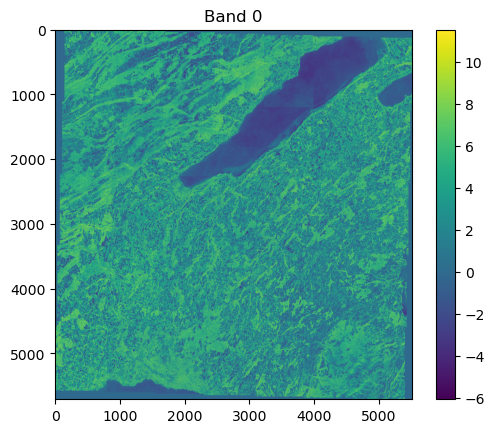

In [8]:
# Show a single band (e.g., first band)
plt.imshow(mosaic[0], cmap="viridis")
plt.colorbar()
plt.title("Band 0")
plt.show()


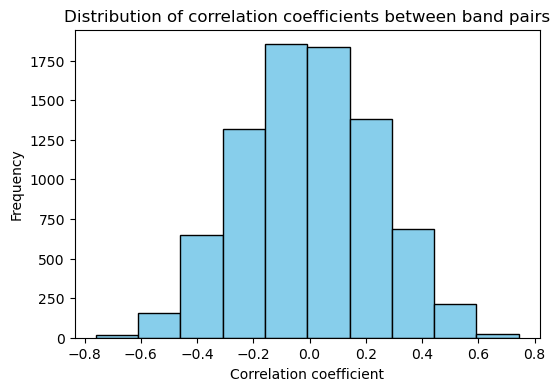

Correlation coefficient quantiles:
0%: -0.759
25%: -0.169
50%: -0.004
75%: 0.168
100%: 0.743
90% quantile: 0.308


In [9]:
# Optional: check correlation among all dimension pairs
from itertools import combinations
bands, height, width = mosaic.shape
n_samples = 50000

# Sample random pixels
rows = np.random.randint(0, height, n_samples)
cols = np.random.randint(0, width, n_samples)

# Extract pixel values (shape: n_samples x bands)
pixel_values = np.array([mosaic[:, r, c] for r, c in zip(rows, cols)])

# Compute correlation coefficients for all band pairs
corr_values = []
band_pairs = list(combinations(range(bands), 2))

for b1, b2 in band_pairs:
    corr = np.corrcoef(pixel_values[:, b1], pixel_values[:, b2])[0, 1]
    corr_values.append(corr)
    # print(f"Correlation Band {b1} vs Band {b2}: {corr:.3f}")

# Plot histogram of correlation coefficients
plt.figure(figsize=(6, 4))
plt.hist(corr_values, bins=10, color='skyblue', edgecolor='black')
plt.xlabel("Correlation coefficient")
plt.ylabel("Frequency")
plt.title("Distribution of correlation coefficients between band pairs")
plt.show()

# Compute quantiles
quantiles = np.quantile(corr_values, [0, 0.25, 0.5, 0.75, 1])
quantile_labels = ["0%", "25%", "50%", "75%", "100%"]
print("Correlation coefficient quantiles:")
for label, q in zip(quantile_labels, quantiles):
    print(f"{label}: {q:.3f}")

# 90th percentile
q90 = np.quantile(corr_values, 0.9)
print(f"90% quantile: {q90:.3f}")